In [3]:
%load_ext autoreload
%autoreload 1
%aimport functions.helpers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, make_scorer
from functions.helpers import convert_feature_types

- Dataset reference: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success
- Competition site: https://www.kaggle.com/competitions/playground-series-s4e6/overview

# Load dataset

In [4]:
df = pd.read_csv('./datasets/train.csv', index_col='id')
print(f'Dataframe before drop_duplicates: {len(df)}')
df.drop_duplicates(inplace=True)
print(f'Dataframe after drop_duplicates: {len(df)}')
df.head()

Dataframe before drop_duplicates: 76518
Dataframe after drop_duplicates: 76518


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [21]:
df = convert_feature_types(df)
y = df['Target']
X = df.drop(['Target'], axis=1)
X.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,0,6,7,6,12.428571,0,11.1,0.6,2.02
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,0,6,9,0,0.000000,0,11.1,0.6,2.02
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,0,8,11,7,12.820000,0,11.1,0.6,2.02
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,0,7,12,6,12.933333,0,7.6,2.6,0.32


# Data Exploration

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

In [10]:
# valores faltantes
df.isnull().sum().sum()

0

In [12]:
df.select_dtypes(include='object')

,Target
id,
0,Graduate
1,Dropout
2,Dropout
3,Enrolled
4,Graduate
...,...
76513,Graduate
76514,Graduate
76515,Enrolled


### Variáveis
- Marital Status: numbers -> Transform into categorical var
- Application mode: numbers -> Transform into categorical var
- Course: numbers -> Transform into categorical var
- Daytime/evening attendance -> transform into categorical var
- Previous qualification -> transform into categorical var
- previous qualification (grade) -> looks like numerical
- Nacionality -> transform into categorical var
- Mother's qualification -> transform into cat var
- Father's qualification -> transform into cat var
- Mother's occupation -> transform into cat var
- Father's occupation -> transform into cat var
- Addmission grade -> looks numericals
- Displaced -> transform into binary var
- Educational special needs -> binary var
- Debtor -> binary var
- Tuition fees up to date -> binary var
- Gender -> binary var
- Scholarship holder -> binary var
- Age at enrollment -> numerical var (ok)
- International -> binary var
- Curricular units -> I'm not sure what this is.

In [56]:
df = convert_feature_types(df)

In [5]:
df.dtypes

Marital status                                    category
Application mode                                  category
Application order                                 category
Course                                            category
Daytime/evening attendance                        category
Previous qualification                            category
Previous qualification (grade)                     float64
Nacionality                                       category
Mother's qualification                            category
Father's qualification                            category
Mother's occupation                               category
Father's occupation                               category
Admission grade                                    float64
Displaced                                         category
Educational special needs                         category
Debtor                                            category
Tuition fees up to date                           catego

<Axes: xlabel='Target', ylabel='count'>

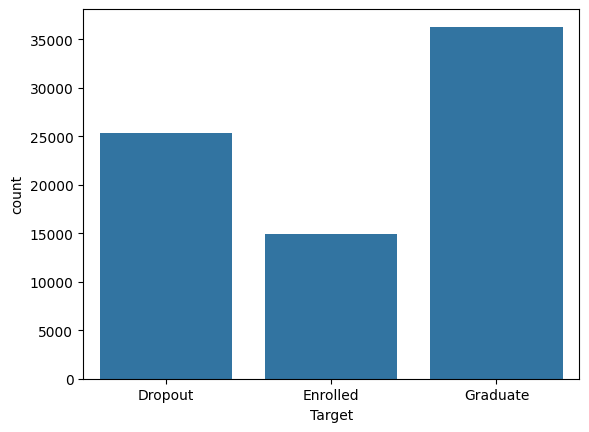

In [57]:
sns.barplot(y.value_counts())

### Comparison between train and test datasets

In [22]:
df_train =  pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

In [23]:
df_test['dataset'] = ['test']*len(df_test)

In [24]:
df_train['dataset'] = ['train']*len(df_train)

In [25]:
df_complete = pd.concat([df_train, df_test])
df_complete.drop('Target', axis=1, inplace=True)

In [53]:
df_complete = convert_feature_types(df_complete)
num_variables = df_complete.select_dtypes(include=['float64']).columns.tolist()

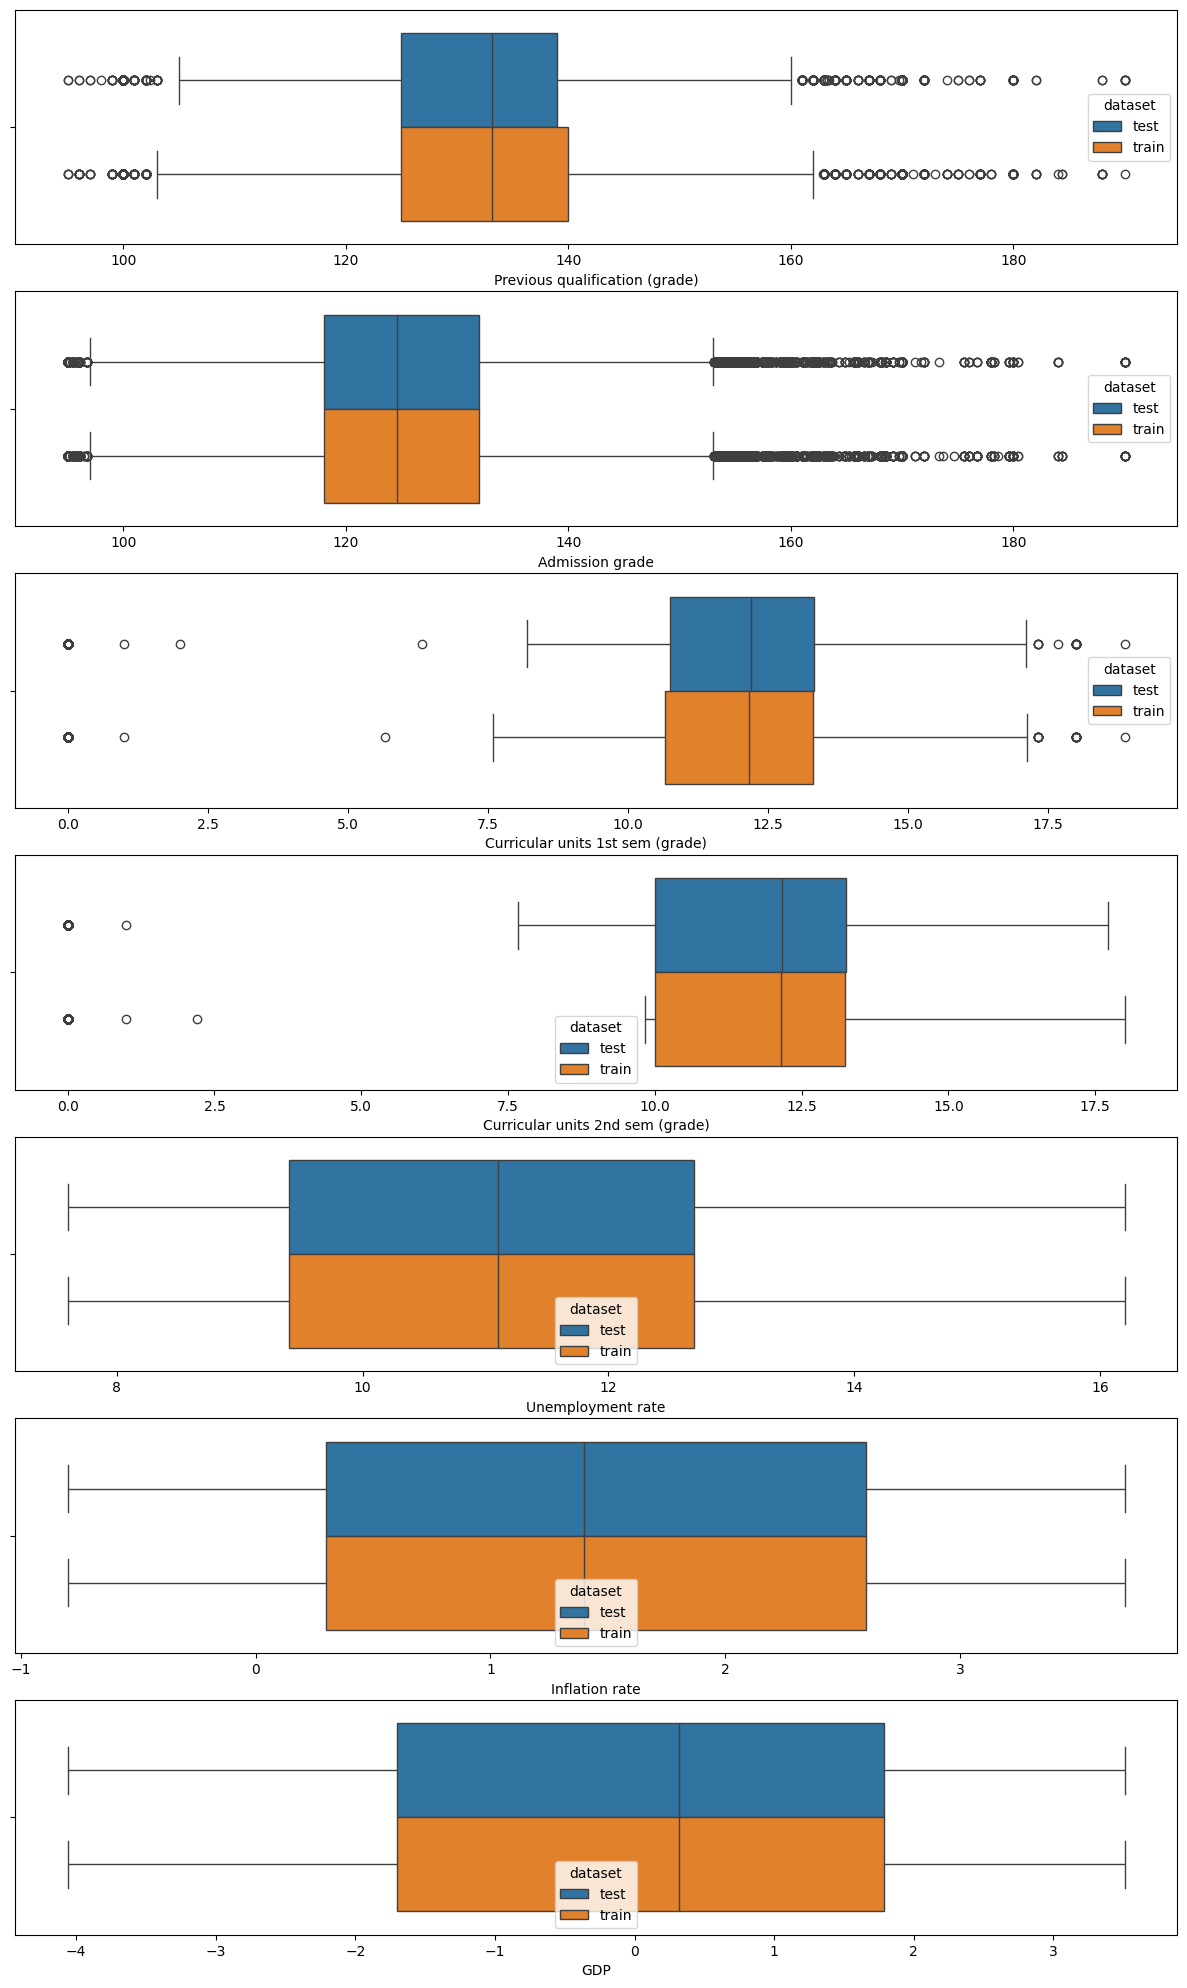

In [58]:
fig, axes = plt.subplots(nrows = len(num_variables), ncols=1, figsize=(15,25))
for i in range(len(num_variables)):
    sns.boxplot(data=df_complete, x=num_variables[i], hue='dataset', ax=axes[i])

They all seem very similar with the exception of 'Curricular units 2nd sem (grade)' whose 25 percentil is higher in test than in train.

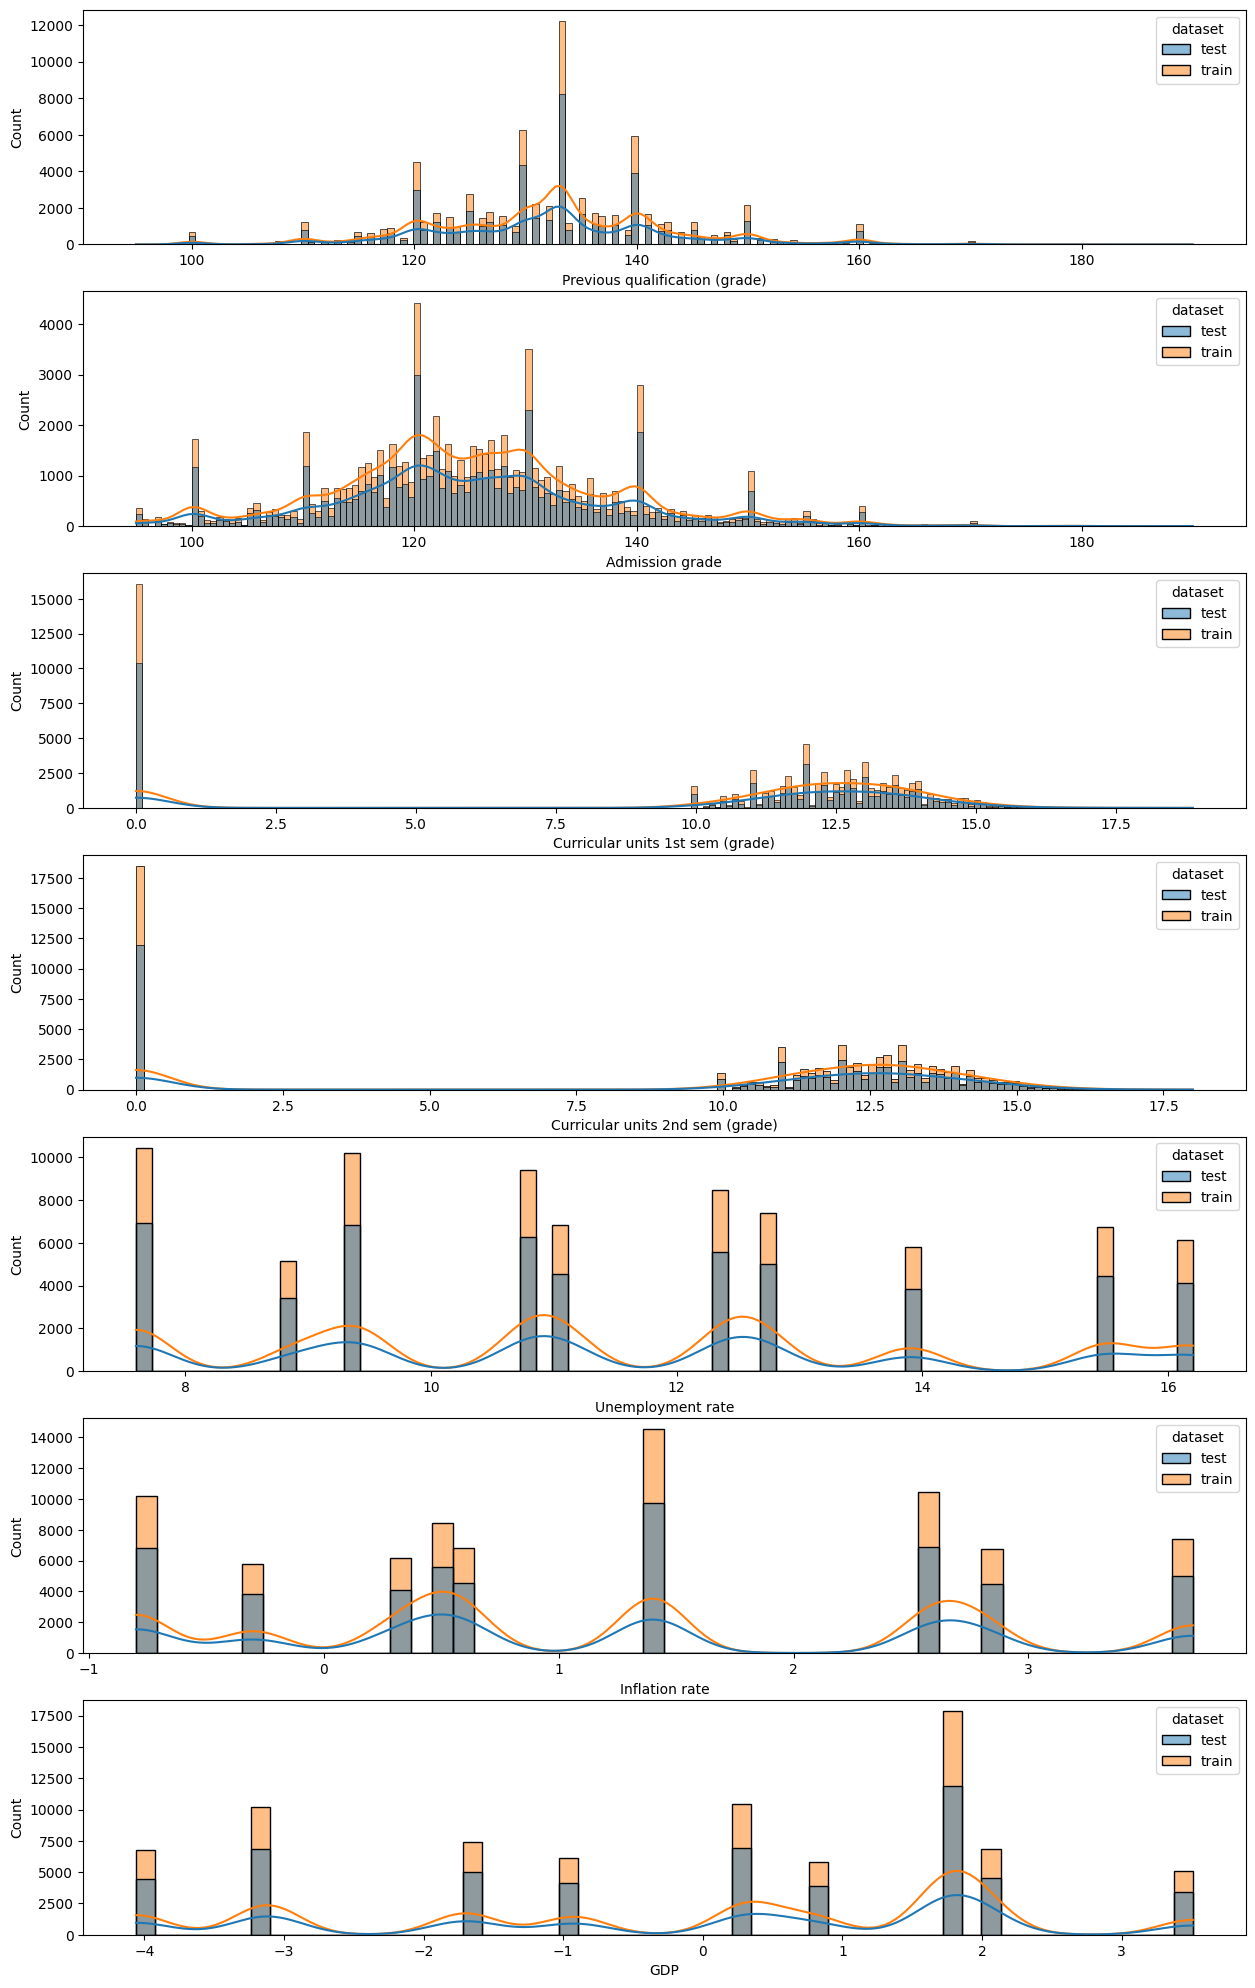

In [60]:
fig, axes = plt.subplots(nrows = len(num_variables), ncols=1, figsize=(15,25))
for i in range(len(num_variables)):
    sns.histplot(data=df_complete, x=num_variables[i], hue='dataset', ax=axes[i], kde=True)

They all look similar.

### How does getting zero grade predicts the outcome?

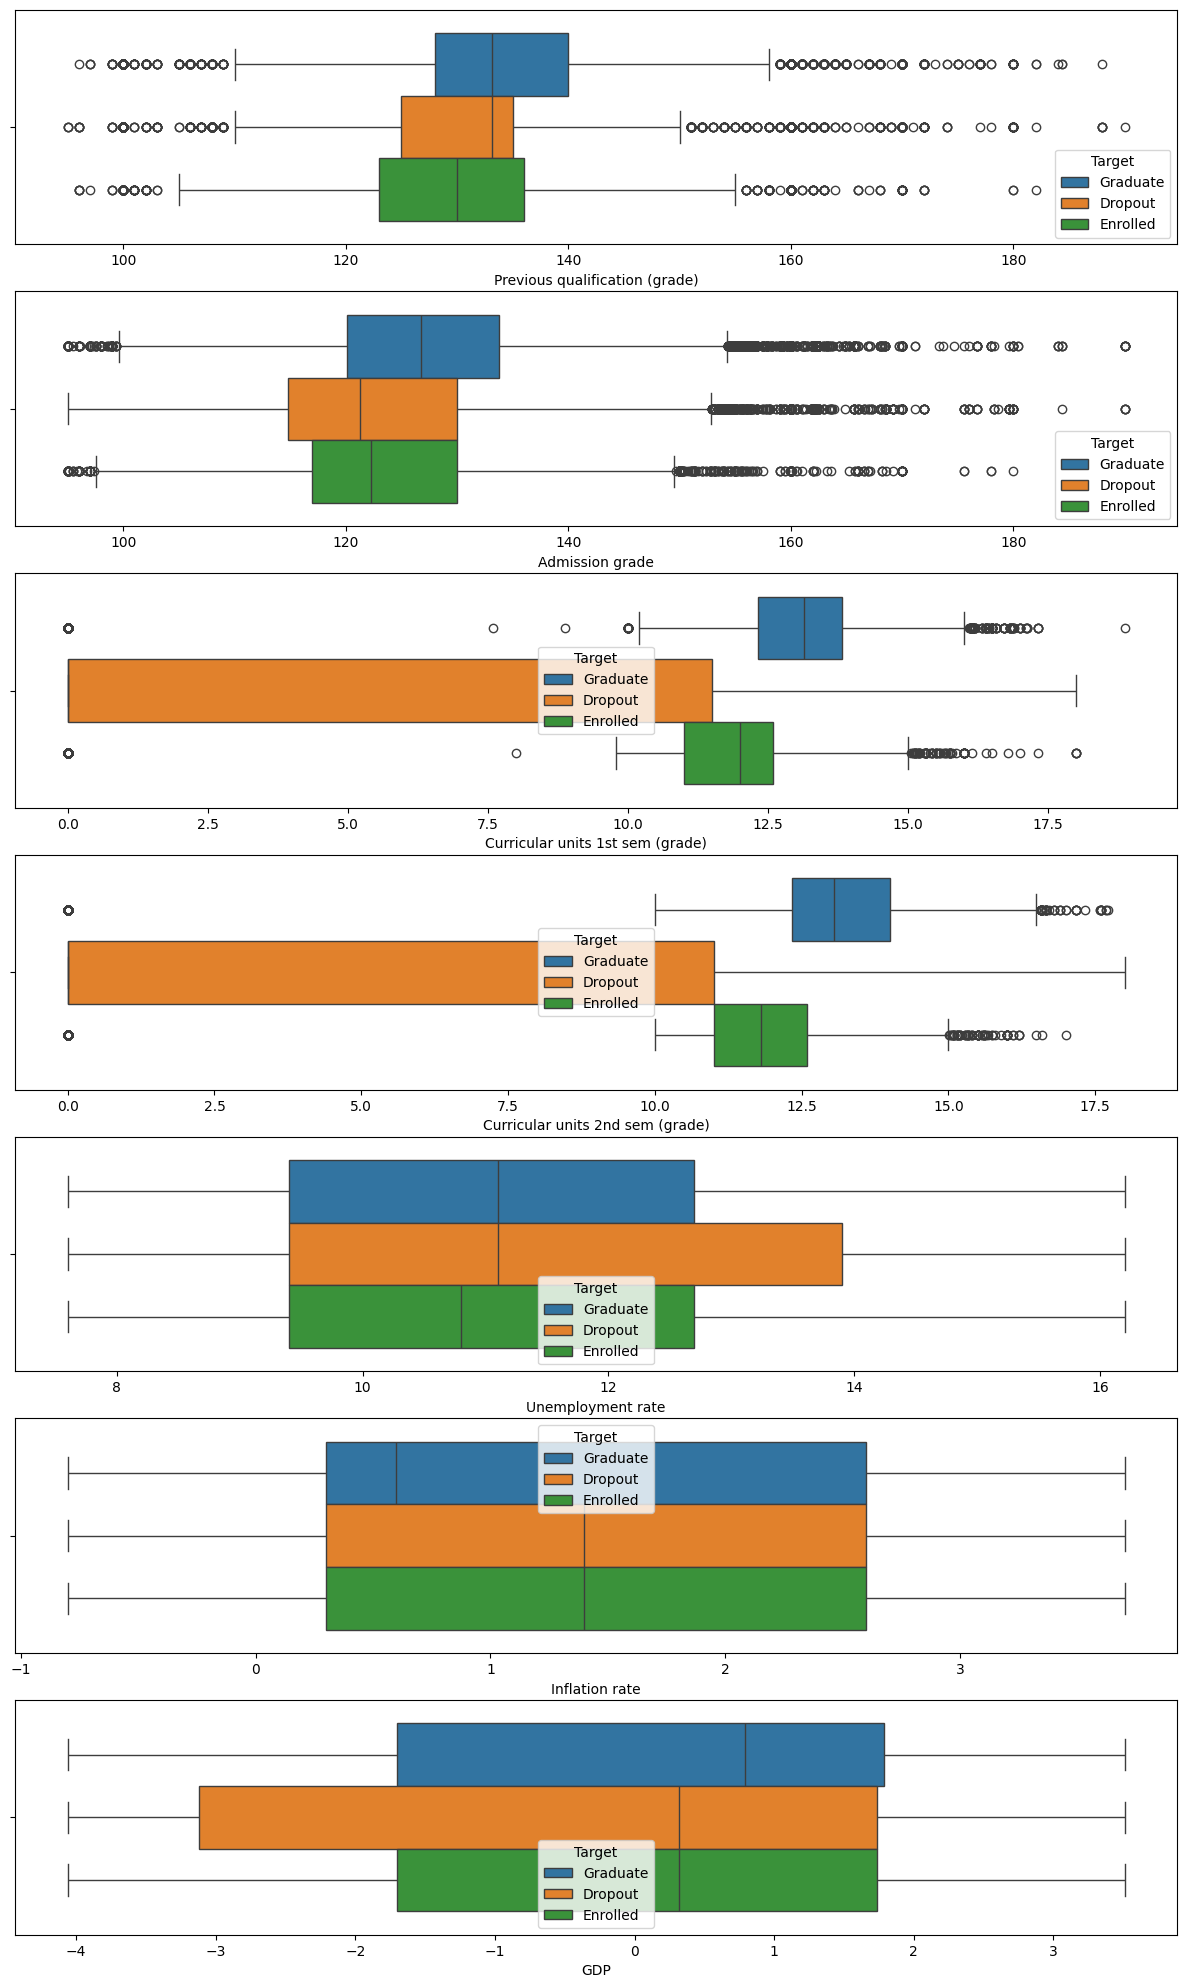

In [64]:
fig, axes = plt.subplots(nrows = len(num_variables), ncols=1, figsize=(15,25))
for i in range(len(num_variables)):
    sns.boxplot(data=df, x=num_variables[i], hue='Target', ax=axes[i])

In [65]:
df[df['Curricular units 1st sem (grade)'] < 10.0]['Target'].value_counts()

Target
Dropout     14857
Enrolled      635
Graduate      550
Name: count, dtype: int64

In [69]:
df[df['Curricular units 1st sem (grade)'] >= 10.0]['Target'].value_counts()

Target
Graduate    35732
Enrolled    14305
Dropout     10439
Name: count, dtype: int64

In [71]:
14857/(14857+635+550) # dropout

0.926131405061713

In [73]:
(35732+14306)/(14305+10439+35732) # enrolled + graduate

0.8274026059924598

In [67]:
df[df['Curricular units 2nd sem (grade)'] < 10.0]['Target'].value_counts()

Target
Dropout     17259
Enrolled      669
Graduate      555
Name: count, dtype: int64

In [70]:
df[df['Curricular units 2nd sem (grade)'] >= 10.0]['Target'].value_counts()

Target
Graduate    35727
Enrolled    14271
Dropout      8037
Name: count, dtype: int64

In [68]:
17259/(17259+669+555)

0.9337769842558026

The average grades of each semester look like a very good indicator of droupouts.

Would it be benefitial the creation of a binary variable of "Grades >= 10.0"?

# Preprocessing

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [23]:
cat_variables = df.drop('Target', axis=1).select_dtypes(include=['category', 'bool']).columns.to_list()
num_variables = df.select_dtypes(include=['int64', 'float64']).columns.to_list()

In [24]:
ct = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_variables),
    ('num', StandardScaler(), num_variables)
])

X_trans = ct.fit_transform(X)

In [25]:
col_names = ct.named_transformers_['cat'].get_feature_names_out().tolist()+ct.named_transformers_['num'].get_feature_names_out().tolist()
X_trans = pd.DataFrame.sparse.from_spmatrix(X_trans, columns=col_names)

In [8]:
X_trans.head()

,Marital status_2,Marital status_3,Marital status_4,Marital status_5,Marital status_6,Application mode_2,Application mode_3,Application mode_4,Application mode_5,Application mode_7,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,0,0,0,0,0,0,0,0,0,0,...,-0.14189,-0.146765,0.040921,-0.066933,0.71866,0.505317,-0.135127,-0.158418,-0.44911,0.933176
1,0,0,0,0,0,0,0,0,0,0,...,-0.14189,-0.146765,0.040921,0.504003,-1.44511,-1.735681,-0.135127,-0.158418,-0.44911,0.933176
2,0,0,0,0,0,0,0,0,0,0,...,-0.14189,-0.146765,0.040921,-2.06521,-1.44511,-1.735681,-0.135127,1.763675,-0.663578,-0.372698
3,0,0,0,0,0,0,0,0,0,0,...,-0.14189,-0.146765,1.270048,1.07494,1.079288,0.575895,-0.135127,-0.158418,-0.44911,0.933176
4,0,0,0,0,0,0,0,0,0,0,...,-0.14189,-0.146765,0.655484,1.360408,0.71866,0.59633,-0.135127,-1.477502,0.98068,0.178079


# Feature Selection

In [9]:
remove_cols = ['Application mode_4', 'Application mode_9', 'Application mode_12',
       'Application mode_26', 'Course_39', 'Course_979',
       'Previous qualification_36', 'Previous qualification_37',
       'Nacionality_17', "Mother's qualification_7",
       "Mother's qualification_8", "Mother's qualification_15",
       "Mother's qualification_27", "Mother's qualification_28",
       "Father's qualification_15", "Father's qualification_20",
       "Father's qualification_23", "Father's qualification_24",
       "Father's qualification_44", "Mother's occupation_11",
       "Mother's occupation_38", "Mother's occupation_101",
       "Mother's occupation_103", "Mother's occupation_127",
       "Mother's occupation_163", "Mother's occupation_172",
       "Father's occupation_12", "Father's occupation_13",
       "Father's occupation_19", "Father's occupation_22",
       "Father's occupation_39", "Father's occupation_96",
       "Father's occupation_132", "Father's occupation_148",
       "Father's occupation_191"]

In [10]:
X_trans.drop(remove_cols, axis=1, inplace=True)

# Outliers

## Isolation Forest

In [32]:
clf = IsolationForest(random_state=42).fit(X_trans)
outliers =  clf.predict(X_trans)

In [33]:
np.sum(outliers == -1)

12

<Axes: xlabel='Curricular units 1st sem (grade)', ylabel='Curricular units 2nd sem (grade)'>

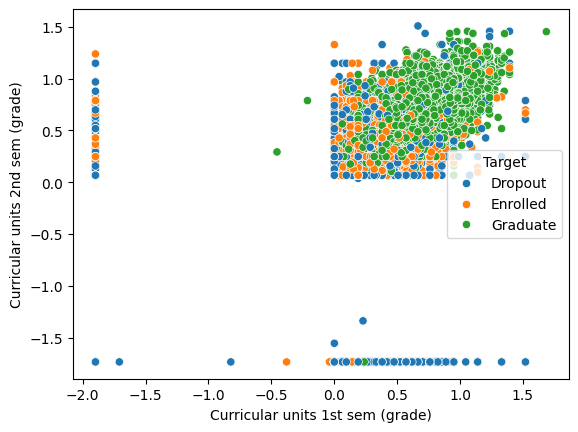

In [34]:
sns.scatterplot(data=X_trans, x='Curricular units 1st sem (grade)', y='Curricular units 2nd sem (grade)', hue=y)

<Axes: xlabel='Curricular units 1st sem (grade)', ylabel='Curricular units 2nd sem (grade)'>

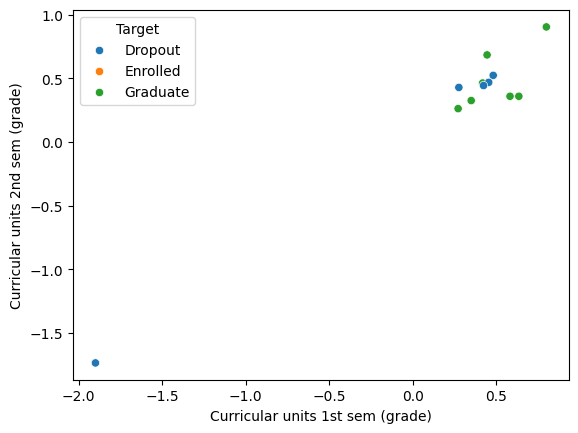

In [35]:
sns.scatterplot(data=X_trans.loc[outliers==-1], 
                x='Curricular units 1st sem (grade)', 
                y='Curricular units 2nd sem (grade)',
                hue=y.loc[outliers==-1])

It does not seem right to include the blue points in the low part of the chart as outliers. They look correct based on the boxplot that I saw for this variable and labels.

## Local Outline Factor

In [26]:
from sklearn.neighbors import LocalOutlierFactor

In [27]:
lof = LocalOutlierFactor()
lof_outliers = lof.fit_predict(X_trans)

In [28]:
np.sum(lof_outliers==-1)

261

In [29]:
np.sum(lof_outliers==1)

76257

<Axes: xlabel='Curricular units 1st sem (grade)', ylabel='Curricular units 2nd sem (grade)'>

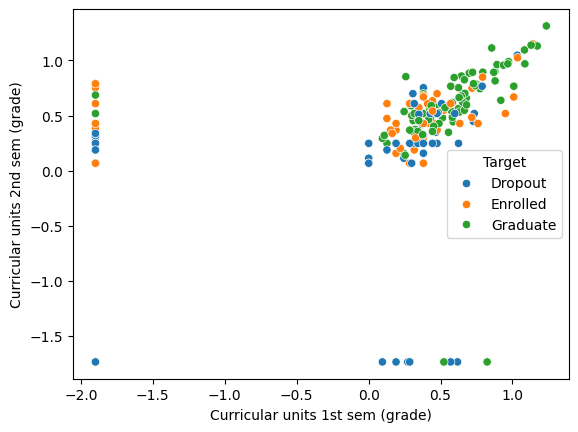

In [31]:
sns.scatterplot(data=X_trans.loc[lof_outliers==-1], 
                x='Curricular units 1st sem (grade)', 
                y='Curricular units 2nd sem (grade)',
                hue=y.loc[lof_outliers==-1])

In [24]:
X_trans.drop(X_trans.loc[lof_outliers == -1].index, inplace=True)

# Optuna

In [164]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create a RandomForestClassifier with the suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    kf = KFold(n_splits=5)
    acc = [] 

    # Train the model
    for i, (train_index, test_index) in enumerate(kf.split(X_trans)):
        print(f'Kfold: {i}')
        clf.fit(X_trans.iloc[train_index], y[train_index])
        y_pred = clf.predict(X_trans.iloc[test_index])
        acc.append(accuracy_score(y[test_index], y_pred))
    
    # Calculate accuracy
    accuracy = np.mean(acc)
    
    return accuracy


In [ ]:
# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and the corresponding accuracy
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)


# AutoGluon

In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor

/home/estacio/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
# AutoGluon does its own preprocessing, therefore I don't need to pass my version of the dataset preprocessed.
df_autogluon = df.drop(df.loc[outliers == -1].index)
df_autogluon = TabularDataset(df_autogluon)
df_autogluon.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [44]:
predictor = TabularPredictor(label='Target', eval_metric='accuracy').fit(df_autogluon, time_limit=10800, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240626_174100"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #41~22.04.2-Ubuntu SMP PREEMPT_DYNAMIC Mon Jun  3 11:32:55 UTC 2
CPU Count:          12
Memory Avail:       2.25 GB / 7.46 GB (30.2%)
Disk Space Avail:   404.85 GB / 467.35 GB (86.6%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of Auto

(_ray_fit pid=14471) [1000]	valid_set's multi_error: 0.16


(_dystack pid=8464) 	0.8325	 = Validation score   (accuracy)
(_dystack pid=8464) 	28.6s	 = Training   runtime
(_dystack pid=8464) 	9.87s	 = Validation runtime
(_dystack pid=8464) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 1245.9s of the 2144.93s of remaining time.
(_dystack pid=8464) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=4.99%)
(raylet) [2024-06-26 14:51:04,302 E 8377 8377] (raylet) node_manager.cc:2967: 15 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: f03346ba33eaf4cc963d572396ccd6cb7afcc047452f51d28e3d3fe6, IP: 192.168.0.153) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.0.153`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-

(_ray_fit pid=17124) [1000]	valid_set's multi_error: 0.177744
(_ray_fit pid=17125) [1000]	valid_set's multi_error: 0.175038
(_ray_fit pid=17121) [1000]	valid_set's multi_error: 0.166686 [repeated 2x across cluster]
(_ray_fit pid=17125) [2000]	valid_set's multi_error: 0.172097 [repeated 4x across cluster]
(_ray_fit pid=17123) [2000]	valid_set's multi_error: 0.16998 [repeated 3x across cluster]
(_ray_fit pid=17125) [3000]	valid_set's multi_error: 0.170686 [repeated 3x across cluster]
(_ray_fit pid=17123) [3000]	valid_set's multi_error: 0.169392 [repeated 3x across cluster]
(_ray_fit pid=17127) [4000]	valid_set's multi_error: 0.160706
(_ray_fit pid=17125) [4000]	valid_set's multi_error: 0.169392
(_ray_fit pid=17123) [4000]	valid_set's multi_error: 0.169039 [repeated 2x across cluster]
(_ray_fit pid=17125) [5000]	valid_set's multi_error: 0.169392


(_dystack pid=8464) 	0.8325	 = Validation score   (accuracy)
(_dystack pid=8464) 	109.1s	 = Training   runtime
(_dystack pid=8464) 	57.48s	 = Validation runtime
(_dystack pid=8464) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 412.14s of the 1311.17s of remaining time.
(_dystack pid=8464) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=2.72%)
(raylet) [2024-06-26 15:05:04,321 E 8377 8377] (raylet) node_manager.cc:2967: 14 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: f03346ba33eaf4cc963d572396ccd6cb7afcc047452f51d28e3d3fe6, IP: 192.168.0.153) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.0.153`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: b4b13fb71fb59f83106abcf6f862e2b08768853101000000 Worker ID: 4458007747e5662353ef48cbd7e6a39be575f2bbc99784d387586543 Node ID: f03346ba33eaf4cc963d572396ccd6cb7afcc047452f51d28e3d3fe6 Worker IP address: 192.168.0.153 Worker port: 40861 Worker PID: 8464 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details: 
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 8320d9f342c8304e22128ac1edb62eed625b1a2effffffff Worker ID: a70af293c830e87b43a1805036e8e58f1c63dc32f61ebe7d5dacc6aa Node ID: f03346ba33eaf4cc963d572396ccd6cb7afcc047452f51d28e3d3fe6 Worker IP address: 192

(_dystack pid=39523) Running DyStack sub-fit ...
(_dystack pid=39523) Beginning AutoGluon training ... Time limit = 2696s
(_dystack pid=39523) AutoGluon will save models to "AutogluonModels/ag-20240626_174100/ds_sub_fit/sub_fit_ho"
(_dystack pid=39523) Train Data Rows:    68005
(_dystack pid=39523) Train Data Columns: 36
(_dystack pid=39523) Label Column:       Target
(_dystack pid=39523) Problem Type:       multiclass
(_dystack pid=39523) Preprocessing data ...
(_dystack pid=39523) Train Data Class Count: 3
(_dystack pid=39523) Using Feature Generators to preprocess the data ...
(_dystack pid=39523) Fitting AutoMLPipelineFeatureGenerator...
(_dystack pid=39523) 	Available Memory:                    2908.58 MB
(_dystack pid=39523) 	Train Data (Original)  Memory Usage: 10.51 MB (0.4% of available memory)
(_dystack pid=39523) 	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
(_dystack pid=39523) 	Stage

In [42]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.8388,accuracy,0.635044,141.450657,0.000638,0.169220,2,True,14
1,LightGBMLarge,0.8352,accuracy,0.012335,1.875418,0.012335,1.875418,1,True,13
2,RandomForestGini,0.8344,accuracy,0.080262,3.658236,0.080262,3.658236,1,True,6
3,NeuralNetFastAI,0.8340,accuracy,0.029227,61.584215,0.029227,61.584215,1,True,3
4,XGBoost,0.8332,accuracy,0.021636,1.708675,0.021636,1.708675,1,True,11
5,LightGBM,0.8312,accuracy,0.005676,0.764436,0.005676,0.764436,1,True,5
6,ExtraTreesEntr,0.8308,accuracy,0.115861,2.753718,0.115861,2.753718,1,True,10
7,NeuralNetTorch,0.8304,accuracy,0.019001,68.579530,0.019001,68.579530,1,True,12
8,LightGBMXT,0.8300,accuracy,0.018592,1.479962,0.018592,1.479962,1,True,4
9,ExtraTreesGini,0.8300,accuracy,0.126118,2.683902,0.126118,2.683902,1,True,9


In [15]:
predictor.model_best

'WeightedEnsemble_L2'

In [20]:
predictor.feature_importance(df_autogluon)

Computing feature importance via permutation shuffling for 36 features using 5000 rows with 5 shuffle sets...


	172.79s	= Expected runtime (34.56s per shuffle set)
	105.91s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.19196,0.006408,1.488334e-07,5,0.205155,0.178765
Curricular units 1st sem (approved),0.03668,0.003984,1.644094e-05,5,0.044883,0.028477
Course,0.03272,0.001616,7.119721e-07,5,0.036048,0.029392
Tuition fees up to date,0.03084,0.002640,6.378369e-06,5,0.036275,0.025405
Admission grade,0.02504,0.002206,7.159169e-06,5,0.029583,0.020497
Curricular units 2nd sem (grade),0.02452,0.005104,2.128618e-04,5,0.035029,0.014011
Previous qualification (grade),0.02316,0.001284,1.128144e-06,5,0.025803,0.020517
Curricular units 2nd sem (evaluations),0.02276,0.003381,5.672374e-05,5,0.029721,0.015799
Application mode,0.02044,0.001835,7.715218e-06,5,0.024219,0.016661
Mother's qualification,0.01984,0.002559,3.248330e-05,5,0.025109,0.014571


# Submission

In [33]:
df_test = pd.read_csv('./datasets/test.csv')
df_test = convert_feature_types(df_test)
id = df_test.pop('id')
df_test = ct.transform(df_test)
df_test = pd.DataFrame.sparse.from_spmatrix(df_test, columns=col_names)
df_test.drop(remove_cols, axis=1, inplace=True)


In [51]:
df_test

,Marital status_2,Marital status_3,Marital status_4,Marital status_5,Marital status_6,Application mode_2,Application mode_3,Application mode_5,Application mode_7,Application mode_10,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,1.270048,-2.065210,-1.445110,-1.735681,-0.135127,0.896848,-1.092515,0.386841
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.040921,-0.352401,0.718660,0.698506,-0.135127,-0.158418,-0.449110,0.933176
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.040921,1.074940,0.358031,0.247731,-0.135127,1.499858,1.123659,-1.767406
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,3.065833,1.270048,1.931344,0.358031,0.247731,-0.135127,-0.987556,0.122806,1.594996
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.040921,0.504003,-0.002597,0.187627,4.192905,-1.477502,0.980680,0.178079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,-3.646459,-2.065210,-1.445110,-1.735681,-0.135127,1.499858,1.123659,-1.767406
51008,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,-0.573642,-0.637869,-1.445110,-1.735681,-0.135127,-0.799116,-1.449963,-1.349882
51009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,-3.646459,-2.065210,-1.445110,-1.735681,-0.135127,1.499858,1.123659,-1.767406
51010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.14189,-0.146765,0.040921,0.504003,-0.363225,0.608351,-0.135127,-1.477502,0.980680,0.178079


In [ ]:
# values from Optuna
clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=27,
        min_samples_split=7,
        min_samples_leaf=1,
        random_state=42
    )

y_pred = clf.fit(X_trans, y).predict(df_test)

In [34]:
# autogluon
df_test = TabularDataset(df_test)
y_pred = predictor.predict(df_test)

In [35]:
len(y_pred.tolist())

51012

In [216]:
len(df_test)

51012

In [36]:
data = {'id': id.tolist(), 'Target': y_pred.tolist()}
submission = pd.DataFrame(data)
submission.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled


In [37]:
submission.to_csv('./submissions/autogluon_model_5_local_outlier_factor_best_qualtiy.csv', index=False)